# Data preparation and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
from pytz import timezone
from tqdm import tqdm


In [2]:
repertory = '../'

In [2]:
file = 'ar41_for_ulb.csv'
N = 2**13
B = 2**6
df = pd.read_csv(repertory+file, sep=';')

## Add weather data to csv file

#### Get weather data from openweathermap

In [ ]:
# from urllib.request import urlopen
# import json
# import csv
# import time
# import datetime


# # Timestamp 1 january 2023 UTC  is	1672531201
# # Each hour, + 3600
# # Each day, + 86400
# # End, 15 september, UTC is 1694818801
# # Duration : 258 days or 22287600 seconds
# # Careful, changement d'heure happening in Belgium but not for UTC

# file = 'csvWeather.csv'
# with open(repertory+file,'w',newline='') as weather :
#     writer = csv.writer(weather)
#     # Write the columns names on the csv
#     fields = ['date','time','temp','wind','humidity']
#     writer.writerow(fields)
#     # For Bxl, Gand and Bastogne, write temperature, wind speed and humidity for each hour and each day between 01/01/23 and 15/09/23
#     for day in range(258):
#         for hour in range(24):
#             urlbx = 'https://history.openweathermap.org/data/2.5/history/city?lat=50.5&lon=4.20&start={}&cnt=1&appid=0ecabdca455f4f022ca58f1a5929a9b7'.format(1672531201+(day*86400)+(hour*3600))
#             data = json.load(urlopen(urlbx))
#             windspeed = data['list'][0]['wind']['speed']
#             temp = data['list'][0]['main']['temp']
#             humidity =  data['list'][0]['main']['humidity']
#             dt = datetime.datetime.fromtimestamp(data['list'][0]['dt'])
#             dt = str(dt).split()
#             writer.writerow([dt[0],dt[1],temp,windspeed,humidity])

#             urlgand = 'https://history.openweathermap.org/data/2.5/history/city?lat=51.03&lon=3.43&start={}&cnt=1&appid=0ecabdca455f4f022ca58f1a5929a9b7'.format(1672531201+(day*86400)+(hour*3600))
#             data = json.load(urlopen(urlgand))
#             windspeed = data['list'][0]['wind']['speed']
#             temp = data['list'][0]['main']['temp']
#             humidity =  data['list'][0]['main']['humidity']
#             writer.writerow([dt[0],dt[1],temp,windspeed,humidity])

#             urlbast = 'https://history.openweathermap.org/data/2.5/history/city?lat=50.0&lon=5.43&start={}&cnt=1&appid=0ecabdca455f4f022ca58f1a5929a9b7'.format(1672531201+(day*86400)+(hour*3600))
#             data = json.load(urlopen(urlbast))
#             windspeed = data['list'][0]['wind']['speed']
#             temp = data['list'][0]['main']['temp']
#             humidity =  data['list'][0]['main']['humidity']
#             writer.writerow([dt[0],dt[1],temp,windspeed,humidity])

#### Combine our dataset with weather data 

In [ ]:
# Find the closest point to define which weather report is the most relevant 
def closest(point, locs):
    close = 9e20
    for j in locs :
        dist = 0
        for i in range (2) :
            dist += (point[i]-j[i])**2
        if np.sqrt(dist) < close :
            close = np.sqrt(dist)
            best = j
    return best

In [ ]:
pathWeather = repertory+'csvWeather.csv'
pathTrain = repertory+'ar41_for_ulb.csv'
weather = pd.read_csv(pathWeather)
train = pd.read_csv(pathTrain,sep=';')

In [ ]:
# Creating a series for each dataframe that contains the closest point of the 3 studied locations
# We chose 3 different towns in Belgium based on their average temperatures. 
# One in the south, rather cold, one in the center and one in the north, rather warm.
locs = [(50.5, 4.2),(51.0,3.43),(50.0,5.43)]
weather['closest'] = list(zip(weather['lat'], weather['lon']))
train['coord'] = list(zip(train['lat'], train['lon']))
train['closest'] = train.apply(lambda row: closest(row['coord'],locs),axis=1)

In [ ]:
train['date'] = train['timestamps_UTC'].str.split().str[0]
train['time'] = train['timestamps_UTC'].str.split().str[1].str[:2]
weather['time'] = pd.to_datetime(weather['time'], format='%H:%M:%S')
weather['time'] = weather['time'].dt.hour.apply(lambda x: str(x).zfill(2))
print(train.shape,weather.shape)
final = pd.merge(train,weather,on=['time','date','closest'],how='inner')
print(final)

In [ ]:
writer = pd.ExcelWriter('final2.xlsx',engine='xlsxwriter') #TODO
final2 = final[final['mapped_veh_id'] < 105]
final2.to_excel(writer,sheet_name='sheet1')
writer.close()
final.to_csv(repertory+'trains_weather.csv',sep=";")

## Filter impossible values

In [3]:
#Read csv with weather data
file = 'trains_weather.csv'
N = 17679273
df = pd.read_csv(repertory+file, sep=';')
df.info()
df = df.iloc[:, :-2].drop(df.columns[16:18], axis=1) #remove some useless columns (closest,lat_y,lon_y)

KeyboardInterrupt: 

In [5]:
'''use file to make fit & ruled_out through rule-based processing.
fitting is not sorted by trains or by time'''

def sep_temp_air(df) :
    upper = 200
    lower = -15 # Determine if it is an overflow (and should be removed) or not
    high = (df["RS_E_InAirTemp_PC1"] > upper) | (df['RS_E_InAirTemp_PC2'] > upper)
    higher = df.copy()[high] #Getting only rows that show an upper error
    higher['hta'] = True #Adding a column to indicate if there's an upper error

    low = (df["RS_E_InAirTemp_PC1"] < lower) | (df['RS_E_InAirTemp_PC2'] < lower)
    lower = df.copy()[low]
    lower['lta'] = True

    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_temp_water(df) :
    upper = 100
    lower = -5 # Determine if it is an overflow (and should be removed) or not
    high = (df["RS_E_WatTemp_PC1"] > upper) | (df['RS_E_WatTemp_PC2'] > upper)
    higher = df.copy()[high]
    higher['htw'] = True
    low = (df["RS_E_WatTemp_PC1"] <= lower) | (df['RS_E_WatTemp_PC2'] <= lower)
    lower = df.copy()[low]
    lower['ltw'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_temp_oil(df) :
    upper = 200
    lower = -100 # Determine if it is an overflow (and should be removed) or not
    high = (df["RS_T_OilTemp_PC1"] > upper) | (df['RS_T_OilTemp_PC2'] > upper)
    higher = df.copy()[high]
    higher['hto'] = True
    low = (df["RS_T_OilTemp_PC1"] < lower) | (df['RS_T_OilTemp_PC2'] < lower)
    lower = df.copy()[low]
    lower['lto'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_rpm(df) :
    upper = 3000
    lower = -1
    high = (df["RS_E_RPM_PC1"] > upper) | (df['RS_E_RPM_PC2'] > upper)
    higher = df.copy()[high]
    higher['hrpm'] = True
    low = (df["RS_E_RPM_PC1"] < lower) | (df['RS_E_RPM_PC2'] < lower)
    lower = df.copy()[low]
    lower['lrpm'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_press(df) :
    upper = 689
    lower = 1 
    high = (df["RS_E_OilPress_PC1"] > upper) | (df['RS_E_OilPress_PC2'] > upper)
    higher = df.copy()[high]
    higher['hpress'] = True
    low = (df["RS_E_OilPress_PC1"] < lower) | (df['RS_E_OilPress_PC2'] < lower)
    lower = df.copy()[low]
    lower['lpress'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

file = 'trains_weather.csv'

df = pd.read_csv(repertory+ file,sep=";",index_col=[0])   
print(df.head())

N = df.shape[0]
df = df.dropna() #12000 NaN's in the PC2 columns
print("Naaan : ", df.shape[0],N-df.shape[0])
ruled_out = df.isna()


fit,h,l = sep_temp_air(df)
print("Temperature air : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out.append(h)
ruled_out = ruled_out.append(l)

fit,h,l = sep_temp_oil(fit)
print("Temperature oil : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out.append(h)
ruled_out = ruled_out.append(l)

fit,h,l = sep_temp_water(fit)
print("Temperature water : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out.append(h)
ruled_out = ruled_out.append(l)

fit,h,l = sep_press(fit)
print("Pressure : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out.append(h)
ruled_out = ruled_out.append(l)

fit,h,l = sep_rpm(fit)
print("RPM : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out.append(h)
ruled_out = ruled_out.append(l)


   Unnamed: 0.1  mapped_veh_id       timestamps_UTC      lat_x     lon_x  \
0             0          181.0  2023-08-01 03:44:12  50.769818  3.872114   
1            17          140.0  2023-08-01 03:16:58  50.342576  4.288712   
2            20          181.0  2023-08-01 03:48:13  50.769820  3.872082   
3           103          153.0  2023-08-01 03:00:49  50.769369  3.871874   
4           104          152.0  2023-08-01 03:14:56  50.320134  4.404903   

   RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0                27.0                23.0              255.0   
1                34.0                35.0              203.0   
2                27.0                24.0              251.0   
3                28.0                29.0              317.0   
4                38.0                38.0              186.0   

   RS_E_OilPress_PC2  RS_E_RPM_PC1  ...  RS_T_OilTemp_PC2  \
0              238.0         794.0  ...              77.0   
1              196.0         795.0  

In [6]:
fit.to_csv(repertory+'fittingtst.csv',sep=';',index=False)
ruled_out.to_csv(repertory+'ruled_outtst.csv',sep=';',index=False)

In [7]:
df = fit

## Visualize time difference 

(16517984, 24)
(16517984, 24)


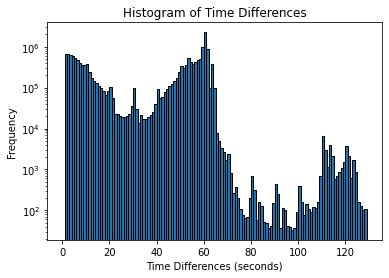

In [8]:
#convert timezone
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'], utc=True)
tzone = timezone('Europe/Paris')
df['timestamps_UTC'] = df['timestamps_UTC'].dt.tz_convert(tzone)

#remove nan
print(df.shape)
df = df.dropna()
print(df.shape)

df = df.sort_values(by=['mapped_veh_id','timestamps_UTC'])
time_diffs = df['timestamps_UTC'].diff().dt.total_seconds()

custom_bins = np.concatenate([np.arange(0, 130, 1)])

# Plot a histogram of the time differences with custom bin edges
plt.hist(time_diffs, bins=custom_bins, edgecolor='black')
plt.yscale("log")
plt.xlabel('Time Differences (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Differences')
plt.show()

## Create time series by train and with regular interval of time between two consecutive timestamps

In [9]:
# Initialisation des variables
time_series_list = [] 
current_time_series = [] 

for i in tqdm(range(len(df)), desc="Processing Rows", unit=" row"):
    # Add first row
    if not current_time_series:
        current_time_series.append(df.iloc[i])
    else:
        # check change of train or difference of time between 2 rows
        train_id_change = df['mapped_veh_id'].iloc[i] != df['mapped_veh_id'].iloc[i - 1]
        time_diff = (df['timestamps_UTC'].iloc[i] - df['timestamps_UTC'].iloc[i - 1]).total_seconds()

        if train_id_change or time_diff > 150: 
            # Add current time serie to result
            time_series_list.append(current_time_series)
            # start new time serie
            current_time_series = [df.iloc[i]]
        else:
            # add row to current time serie
            current_time_series.append(df.iloc[i])

# add last time serie to result
if current_time_series:
    time_series_list.append(current_time_series)

Processing Rows:  27%|██▋       | 4408043/16517984 [33:23<56:57, 3543.06 row/s]   

Maintenant que j'ai ce code j'aimerais pour chaque timeseries, parcourir chacune de leur rows et prendre leur timestamps, les arrondir à la seconde la plus proche, ensuite j'aimerais appliquer un modulo 60 sur ce timestamps et le reste de ce modulo (qui va donc de 0 à 59) représente l'index du nouveau tableau que je veux créer où on va mettre la current row. Cela me permettra ainsi de voir à quel offset il y a le plus de rows avec des intervals de 60 secondes

In [ ]:
import pandas as pd

# Supposons que vous avez déjà la liste de time_series_list

# Initialisation d'un dictionnaire pour stocker les compteurs d'offsets
offset_counters = {}

# Parcourir chaque série temporelle dans la liste
for time_series in time_series_list:
    # Initialiser un dictionnaire pour chaque série temporelle
    time_series_offsets = {}

    # Parcourir chaque ligne de la série temporelle
    for i in range(len(time_series)):
        # Arrondir le timestamp à la seconde la plus proche
        rounded_timestamp = round(time_series[i]['timestamps_UTC'].timestamp())

        # Appliquer le modulo 60
        offset = rounded_timestamp % 60

        # Ajouter l'offset à la liste ou incrémenter le compteur
        if offset not in time_series_offsets:
            time_series_offsets[offset] = 1
        else:
            time_series_offsets[offset] += 1

    # Trouver l'offset avec le plus grand nombre de rows
    max_offset = max(time_series_offsets, key=time_series_offsets.get)

    # Ajouter l'offset au dictionnaire global
    if max_offset not in offset_counters:
        offset_counters[max_offset] = 1
    else:
        offset_counters[max_offset] += 1

# Trouver l'offset global avec le plus grand nombre de rows
max_global_offset = max(offset_counters, key=offset_counters.get)

print(f"L'offset global avec le plus grand nombre de rows est : {max_global_offset}")


In [ ]:
''' Add n_n1 to df '''
#n_n1 represents the time difference T(n) between samples n and n_1 (first item is 0)
df = df.sort_values(by=['mapped_veh_id','timestamps_UTC']).reset_index()
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'], utc=True)
#tzone = timezone('Europe/Paris')
#df['timestamps_UTC'] = df['timestamps_UTC'].dt.tz_convert(tzone)

n_n1 = df['timestamps_UTC'].diff().dt.total_seconds()
n_n1 = n_n1.to_frame(name='n_n1')
n_n1 = n_n1.fillna(0)
df.insert(3,'n_n1',n_n1)
#drop time intervals 
tau = 12
df = df[((df['n_n1'] >= 60-tau) & (df['n_n1'] <= 60+tau)) | (df['n_n1'] >= 120-tau) & (df['n_n1'] <= 120+tau)]


In [ ]:
sortedByTrain = df.sort_values(by=['mapped_veh_id','timestamps_UTC']).reset_index()
sortedByTrain['timestamps_UTC'] = pd.to_datetime(sortedByTrain['timestamps_UTC'], utc=True)

In [ ]:
# Adding a trajets column 

sortedByTrain['sequence_start'] = sortedByTrain['timestamps_UTC'].diff().dt.total_seconds() > 150

sortedByTrain['traj'] = sortedByTrain['sequence_start'].cumsum()
print(sortedByTrain['traj'].drop_duplicates())
sortedByTrain = sortedByTrain.drop(['sequence_start','date','time'],axis = 1)

print(sortedByTrain[['traj','timestamps_UTC','n_n1']].head(10))

In [ ]:
df2 = pd.DataFrame(columns=sortedByTrain.columns)
print(df2)
global add 
add = -1 

def gb_to_rows(gb) :
    gb.apply(lambda w: addrow(w,df2),axis=1)
    print(gb['traj'].drop_duplicates())
def addrow(row,df2) :
    global add
    if row['n_n1'] > 90 :
        df2.loc[add,'timestamps_UTC'] = row['timestamps_UTC'] + dt.timedelta(seconds=60)
        df2.loc[add,'mapped_veh_id'] = row['mapped_veh_id']
        df2.loc[add,'traj'] = row['traj']
        add -= 1

In [ ]:
import datetime as dt
sortedByTrain.groupby('traj').apply(lambda z: gb_to_rows(z))

In [ ]:
print(df2.shape)
df = pd.concat([sortedByTrain,df2])
print(sortedByTrain.shape)
print(df.shape)
df=df.interpolate()
print(df.shape)

In [ ]:
sortedByTrain.to_csv(dirpath/'trajets_train.csv',sep=',')

In [ ]:
sortedByTrain = sortedByTrain[['mapped_veh_id','timestamps_UTC','traj']]
meantrajlength = sortedByTrain.groupby('traj').count().agg('mean')
print(meantrajlength)
print(sortedByTrain[sortedByTrain['traj'] == 183182])

## Creation of time series

In [5]:
# sorting + drop na
# Conversion du fuseau horaire
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'], utc=True)
tzone = timezone('Europe/Paris')
df['timestamps_UTC'] = df['timestamps_UTC'].dt.tz_convert(tzone)

# Suppression des valeurs manquantes
df = df.dropna()

# Tri du DataFrame par 'mapped_veh_id' puis 'timestamps_UTC'
df = df.sort_values(by=['mapped_veh_id', 'timestamps_UTC'])

### Creation of time series (we consider a new time series when, between two timestamps, the train change or the difference of time is greater than 10 minutes)

In [ ]:

# Initialize variables
time_series_list = []
current_time_series = []
current_time_series.append(df.head(1))

# Use tqdm to add a progress bar
for i in tqdm(range(1, len(df)), desc="Processing Rows", unit=" row"):
    # Check if it's the same train
    if df['mapped_veh_id'].iloc[i] == df['mapped_veh_id'].iloc[i - 1]:
        # Calculate time difference in seconds
        time_diff = (df['timestamps_UTC'].iloc[i] - df['timestamps_UTC'].iloc[i - 1]).total_seconds()

        # Check for gaps greater than 5 minutes
        if time_diff > 300:
            # If gap is too large, start a new time series
            if current_time_series:
                time_series_list.append(current_time_series)
            current_time_series = []
        else:
            current_time_series.append(df.iloc(i))
    # Create new time series if it is a new train
    else : 
        if current_time_series:
            time_series_list.append(current_time_series)
        current_time_series = []


In [ ]:
import pandas as pd
from pytz import timezone
from tqdm import tqdm

# Assuming df is your DataFrame

# sorting + drop na
# Conversion du fuseau horaire
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'], utc=True)
tzone = timezone('Europe/Paris')
df['timestamps_UTC'] = df['timestamps_UTC'].dt.tz_convert(tzone)

# Suppression des valeurs manquantes
df = df.dropna()

# Tri du DataFrame par 'mapped_veh_id' puis 'timestamps_UTC'
df = df.sort_values(by=['mapped_veh_id', 'timestamps_UTC'])

# Initialize variables
time_series_list = []
current_time_series = []
current_time_series.append(df.head(1))

# Iterate over possible starting points (offsets)
max_timestamps = 0
best_offset = 0

for offset in tqdm(range(60), desc="Searching for Best Offset", unit="second"):
    current_time_series = []
    current_time_series.append(df.head(1))

    # Use tqdm to add a progress bar
    for i in range(1, len(df)):
        # Calculate time difference in seconds with the offset
        time_diff = (df['timestamps_UTC'].iloc[i] - df['timestamps_UTC'].iloc[i - 1]).total_seconds() + offset

        # Check for gaps greater than 60 seconds
        if time_diff > 60:
            # If gap is too large, start a new time series
            if current_time_series:
                time_series_list.append(current_time_series)
            current_time_series = []
        else:
            current_time_series.append(df.iloc[i])

    # Create new time series if it is a new train
    if current_time_series:
        time_series_list.append(current_time_series)

    # Update best offset if the current offset gives more timestamps
    if len(current_time_series) > max_timestamps:
        max_timestamps = len(current_time_series)
        best_offset = offset

print(f"Best Offset: {best_offset}")


In [ ]:
for time_series in time_series_list:
    for i in range(0, 59):
        
        for df_chunk in time_series:

## Clean and sort dataset 

In [ ]:
def sep_temp_air(df) :
    upper = 80
    lower = 0 # Determine if it is an overflow (and should be removed) or not
    high = (df["RS_E_InAirTemp_PC1"] > upper) | (df['RS_E_InAirTemp_PC2'] > upper)
    higher = df.copy()[high] #Getting only rows that show an upper error
    higher['hta'] = True #Adding a column to indicate if there's an upper error

    low = (df["RS_E_InAirTemp_PC1"] < lower) | (df['RS_E_InAirTemp_PC2'] < lower)
    lower = df.copy()[low]
    lower['lta'] = True

    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_temp_water(df) :
    upper = 100
    lower = 0 # Determine if it is an overflow (and should be removed) or not
    high = (df["RS_E_WatTemp_PC1"] > upper) | (df['RS_E_WatTemp_PC2'] > upper)
    higher = df.copy()[high]
    higher['htw'] = True
    low = (df["RS_E_WatTemp_PC1"] <= lower) | (df['RS_E_WatTemp_PC2'] <= lower)
    lower = df.copy()[low]
    lower['ltw'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_temp_oil(df) :
    upper = 100
    lower = 0 # Determine if it is an overflow (and should be removed) or not
    high = (df["RS_T_OilTemp_PC1"] > upper) | (df['RS_T_OilTemp_PC2'] > upper)
    higher = df.copy()[high]
    higher['hto'] = True
    low = (df["RS_T_OilTemp_PC1"] < lower) | (df['RS_T_OilTemp_PC2'] < lower)
    lower = df.copy()[low]
    lower['lto'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_rpm(df) :
    upper = 3000
    lower = 0
    high = (df["RS_E_RPM_PC1"] > upper) | (df['RS_E_RPM_PC2'] > upper)
    higher = df.copy()[high]
    higher['hrpm'] = True
    low = (df["RS_E_RPM_PC1"] < lower) | (df['RS_E_RPM_PC2'] < lower)
    lower = df.copy()[low]
    lower['lrpm'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower

def sep_press(df) :
    upper = 600
    lower = 100 
    high = (df["RS_E_OilPress_PC1"] > upper) | (df['RS_E_OilPress_PC2'] > upper)
    higher = df.copy()[high]
    higher['hpress'] = True
    low = (df["RS_E_OilPress_PC1"] < lower) | (df['RS_E_OilPress_PC2'] < lower)
    lower = df.copy()[low]
    lower['lpress'] = True
    fitting = df[~(high | low)]
    return fitting, higher, lower


def sep_cap_diff(df) :
    column_name=df.columns[4:]
    sensor_columns = column_name
    sensor_columnsPC1 = sensor_columns[::2]
    sensor_columnsPC2 = sensor_columns[1::2]
    reldiff = 0.5
    diff = pd.DataFrame()
    allzero = pd.DataFrame()
    fitting = df.copy()
    for i in range(len(sensor_columnsPC1)):    
        close = (np.isclose(fitting[sensor_columnsPC1[i]], \
                           fitting[sensor_columnsPC2[i]], rtol=reldiff) & (fitting[sensor_columnsPC1[i]] != 0) & (fitting[sensor_columnsPC2[i]] != 0))
        invalid = ((fitting[sensor_columnsPC1[i]] == 0) & (fitting[sensor_columnsPC2[i]] == 0))
        diff = diff._append(fitting[~close])
        allzero = allzero._append(fitting[invalid])
        fitting = fitting[close & ~invalid]
        print("dshape : ",  diff.shape)
    diff['different'] = True
    allzero['allzero'] = True
    return fitting, diff, allzero
    
df = pd.read_csv(file,sep=";",index_col=[0])   
print(df.head())


fit,h,l = sep_temp_air(df)
print("Temperature air : ", fit.shape, h.shape, l.shape)
ruled_out = h
ruled_out = ruled_out._append(l)

fit,h,l = sep_temp_oil(fit)
print("Temperature oil : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out._append(h)
ruled_out = ruled_out._append(l)

fit,h,l = sep_temp_water(fit)
print("Temperature water : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out._append(h)
ruled_out = ruled_out._append(l)

fit,h,l = sep_press(fit)
print("Pressure : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out._append(h)
ruled_out = ruled_out._append(l)

fit,h,l = sep_rpm(fit)
print("RPM : ", fit.shape, h.shape, l.shape)
ruled_out = ruled_out._append(h)
ruled_out = ruled_out._append(l)


fit, diff, az = sep_cap_diff(fit)
print("Sensor diff : ",fit.shape, diff.shape, az.shape)
ruled_out= ruled_out._append(diff)
ruled_out= ruled_out._append(az)
ruled_out = ruled_out[~ruled_out.index.duplicated(keep='first')]
print("ruled out df : ",ruled_out.shape)

fit.to_csv(dirpath/'fitting.csv',sep=';')
ruled_out.to_csv(dirpath/'ruled_out.csv',sep=';')


In [ ]:
# Convert the 'timestamps_UTC' column to datetime type
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'])

# Sort the DataFrame by the 'timestamps_UTC' column
df_sorted = df.sort_values(by='timestamps_UTC')

# new_file = 'sorted_ar41_for_ulb.csv'

# # Save the sorted DataFrame to a new CSV file
# df_sorted.to_csv(repertory+new_file, index=False)

In [ ]:
# df_sorted = df
# Select the first 100 rows
df_subset = df_sorted.head(N)

# Check for missing values in each column
missing_values_column = df_subset.isnull().sum()

# Check if there are any missing values in the entire DataFrame
any_missing_values = df_subset.isnull().values.any()

total_missing_values = missing_values_column.sum()

# Display the results
print("Missing values in each column:\n", missing_values_column)
print("\nAre there any missing values in the DataFrame?", any_missing_values)
print("Nombre total de valeurs manquantes dans le DataFrame:", total_missing_values)


Missing values in each column:
 Unnamed: 0            0
mapped_veh_id         0
timestamps_UTC        0
lat                   0
lon                   0
RS_E_InAirTemp_PC1    0
RS_E_InAirTemp_PC2    9
RS_E_OilPress_PC1     0
RS_E_OilPress_PC2     9
RS_E_RPM_PC1          0
RS_E_RPM_PC2          9
RS_E_WatTemp_PC1      0
RS_E_WatTemp_PC2      9
RS_T_OilTemp_PC1      0
RS_T_OilTemp_PC2      9
dtype: int64

Are there any missing values in the DataFrame? True
Nombre total de valeurs manquantes dans le DataFrame: 45


In [ ]:
df_sub_subset = df_subset.iloc[:1000]

current_set = df_sub_subset
# Interpolate missing values using linear interpolation
df_interpolated = current_set.interpolate()

# Check if there are any missing values after interpolation
any_missing_values_after_interpolation = df_interpolated.isnull().values.any()

# Display the results
print("Are there any missing values in the DataFrame after interpolation?", any_missing_values_after_interpolation)


Are there any missing values in the DataFrame after interpolation? False


In [ ]:
# Interpolate missing values using polynomial interpolation of order 2
df_interpolated_polynomial = current_set.interpolate(method='polynomial', order=2)


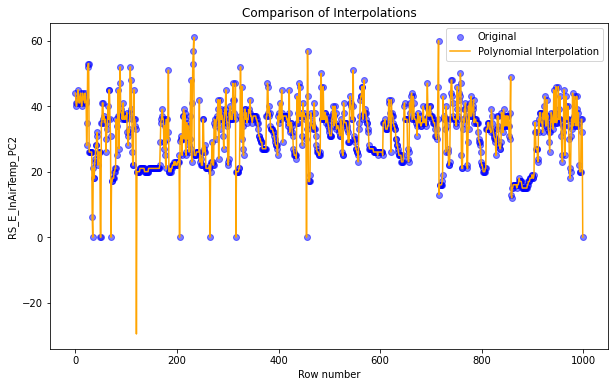

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Original Data
plt.scatter(range(len(current_set)), current_set['RS_E_InAirTemp_PC2'], label='Original', marker='o', color='blue', alpha=0.5)

# Linear Interpolation
# plt.plot(range(len(df_interpolated)), df_interpolated['RS_E_InAirTemp_PC2'], label='Linear Interpolation', color='green')

# Polynomial Interpolation
plt.plot(range(len(df_interpolated_polynomial)), df_interpolated_polynomial['RS_E_InAirTemp_PC2'], label='Polynomial Interpolation', color='orange')

# Customize the plot
plt.xlabel('Row number')
plt.ylabel('RS_E_InAirTemp_PC2')
plt.title('Comparison of Interpolations')
plt.legend()
plt.show()

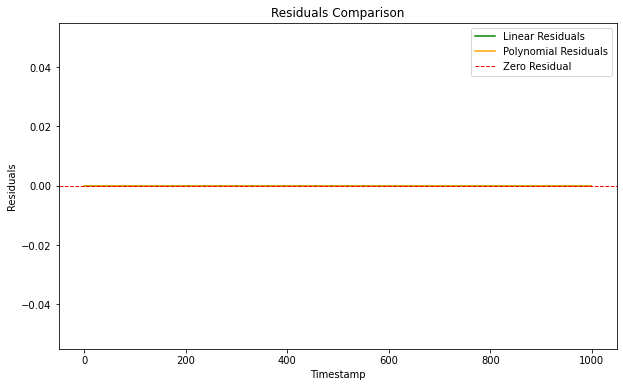

In [ ]:
# Calculate residuals
residuals_linear = current_set['RS_E_InAirTemp_PC2'] - df_interpolated['RS_E_InAirTemp_PC2']
residuals_polynomial = current_set['RS_E_InAirTemp_PC2'] - df_interpolated_polynomial['RS_E_InAirTemp_PC2']

# Plot residuals
plt.figure(figsize=(10, 6))

plt.plot(range(len(current_set)), residuals_linear, label='Linear Residuals', color='green')
plt.plot(range(len(current_set)), residuals_polynomial, label='Polynomial Residuals', color='orange')

plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Residual')

plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.title('Residuals Comparison')
plt.legend()
plt.show()

In [ ]:
unique_count = df['mapped_veh_id'].nunique()
print(f'Total number of unique values: {unique_count}')

Total number of unique values: 92


## Standardization of the data

## Autocorrelation

Index(['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1',
       'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1',
       'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2'],
      dtype='object')


<Figure size 720x432 with 0 Axes>

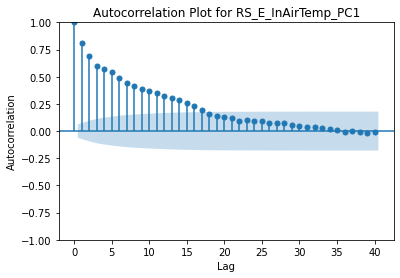

c:\Users\Vincent\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<Figure size 720x432 with 0 Axes>

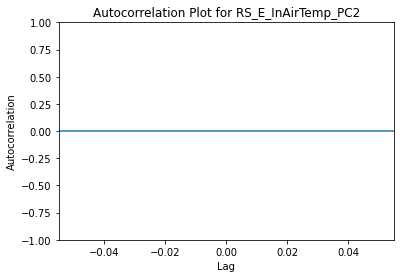

<Figure size 720x432 with 0 Axes>

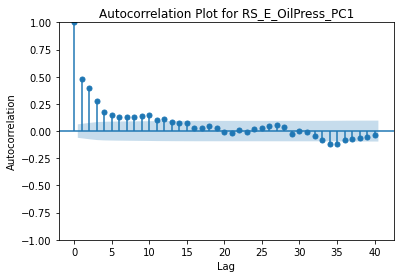

<Figure size 720x432 with 0 Axes>

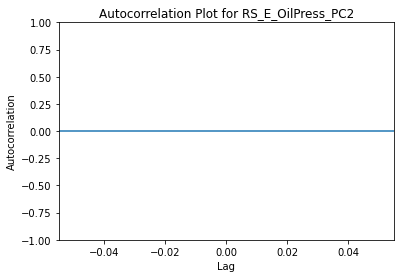

<Figure size 720x432 with 0 Axes>

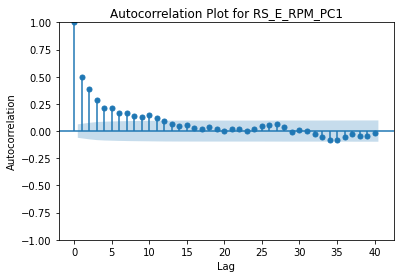

<Figure size 720x432 with 0 Axes>

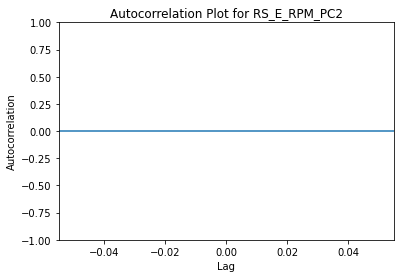

<Figure size 720x432 with 0 Axes>

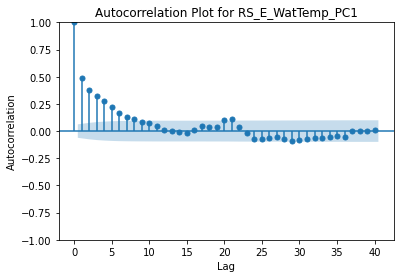

<Figure size 720x432 with 0 Axes>

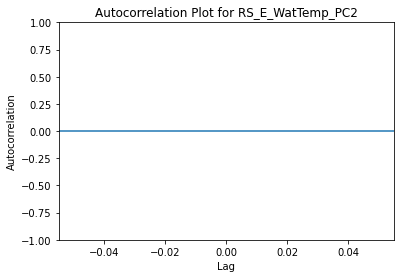

<Figure size 720x432 with 0 Axes>

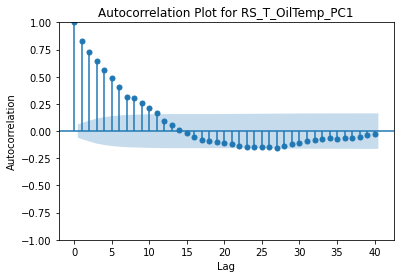

<Figure size 720x432 with 0 Axes>

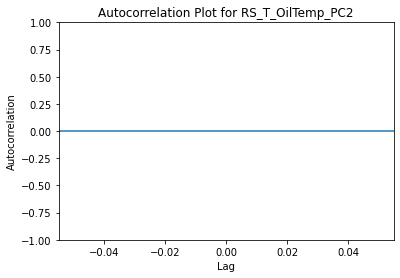

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_autocorrelation(df, column_name, lags=40):
    """
    Plot autocorrelation for a specific column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the time series data.
    - column_name (str): The name of the column for which to plot the autocorrelation.
    - lags (int): Number of lags to include in the plot.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plot_acf(df[column_name], lags=lags)
    plt.title(f'Autocorrelation Plot for {column_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

selected_columns = current_set.columns[5:]
print(selected_columns)

# selected_columns = current_set.columns[6]
for column_name in selected_columns:
    plot_autocorrelation(current_set, column_name)

## Check stationarity or non stationarity of time series

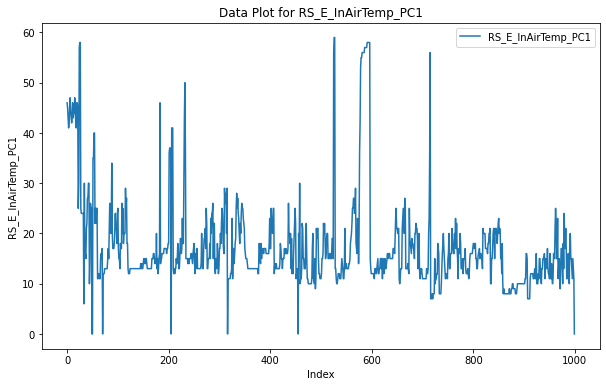

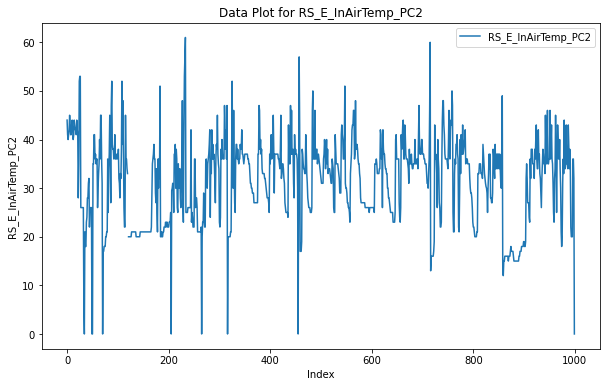

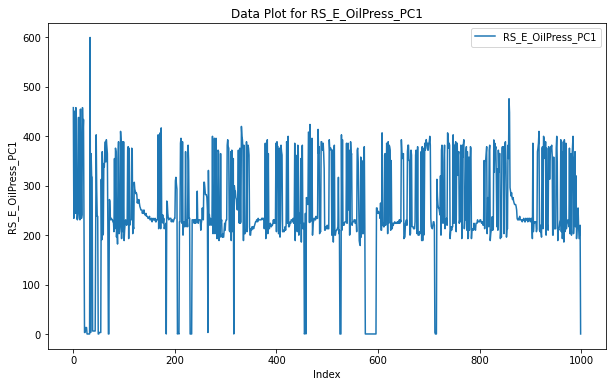

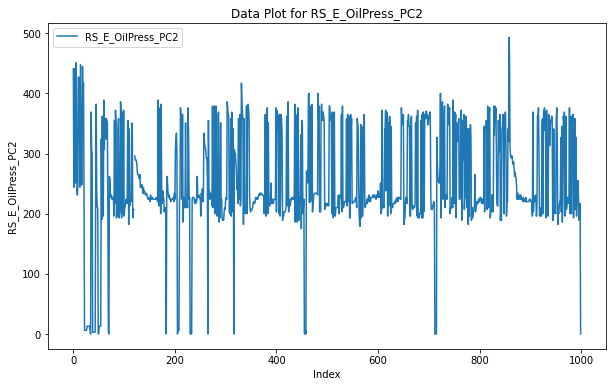

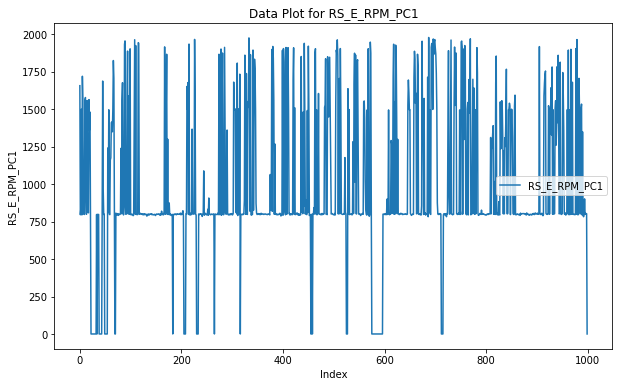

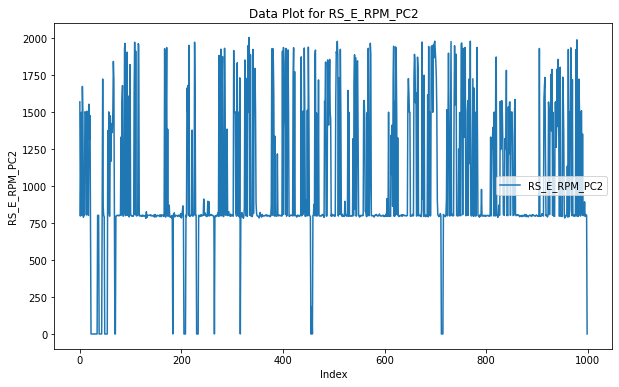

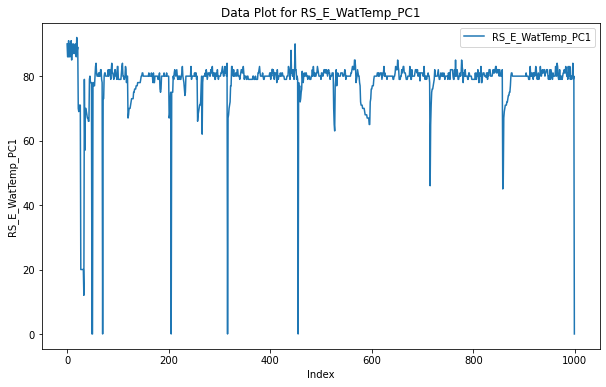

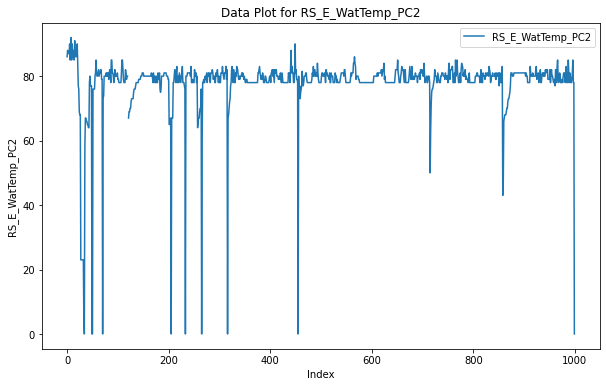

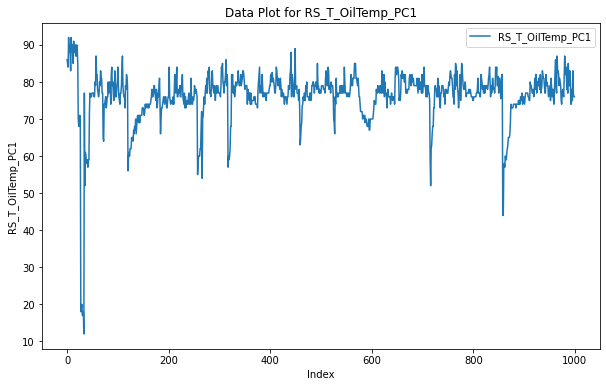

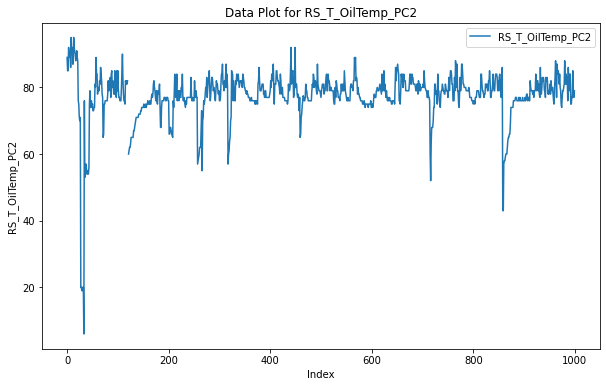

In [ ]:
# Columns from 5th to 8th (index 4 to 7)
selected_columns = current_set.columns[5:]

for column_name in selected_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(current_set.index, current_set[column_name], label=column_name)
    plt.title(f'Data Plot for {column_name}')
    plt.xlabel('Index')  # Use 'Index' instead of 'Timestamp'
    plt.ylabel(column_name)
    plt.legend()
    plt.show()